## Web References

### System

- [How to copy a file without using scp inside an ssh session?](https://superuser.com/questions/291423/how-to-copy-a-file-without-using-scp-inside-an-ssh-session)

### PySpark

- [Complete Machine Learning Project with PySpark MLlib Tutorial](https://www.youtube.com/watch?v=1a7bB1ZcZ3k)
- [The ONLY PySpark Tutorial You Will Ever Need.](https://www.youtube.com/watch?v=cZS5xYYIPzk)
- [PySpark When Otherwise | SQL Case When Usage](https://sparkbyexamples.com/pyspark/pyspark-when-otherwise/)
- [Spark rlike() Working with Regex Matching Examples](https://sparkbyexamples.com/spark/spark-rlike-regex-matching-examples/)
- [spark dataframe drop duplicates and keep first](https://stackoverflow.com/questions/38687212/spark-dataframe-drop-duplicates-and-keep-first)
- [Spark SQL Window functions using plain SQL](https://www.linkedin.com/pulse/spark-sql-window-functions-using-plain-ram-ghadiyaram/)
- [Calculate difference with previous row in PySpark](https://www.arundhaj.com/blog/calculate-difference-with-previous-row-in-pyspark.html)

### Time Series

- [Time Series Analysis with Spark](https://www.youtube.com/watch?v=tKkneWcAIqU)

### Anomaly Detection

- [How to Build an Anomaly Detection Engine with Spark, Akka and Cassandra](https://learning.oreilly.com/videos/how-to-build/9781491955253/9781491955253-video244545/)
- [Real Time Detection of Anomalies in the Database Infrastructure using Apache Spark](https://www.youtube.com/watch?v=1IsMMmug5q0)

### Other

- [What is CRISP DM?](https://www.datascience-pm.com/crisp-dm-2/)

### Internet Traffic

- [Data mining approach for predicting the daily Internet data traffic of a smart university](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0176-5)

## Import Libraries

In [35]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, asc, desc, col, lag, isnull
from pyspark.sql.window import Window

import matplotlib.pyplot as plt
import seaborn as sns

## HDFS Preparation

In [3]:
%%bash
#!/bin/bash

# delete the 
if hadoop fs -test -d router; then
    # delete the output directory
    hadoop fs -rm -r router/output

    # create a new output directory
    hadoop fs -mkdir router/output
else
    # create the router directory and upload the input files
    hadoop fs -mkdir router
    hadoop fs -mkdir router/sample
    hadoop fs -put data/bandwidth.csv router/sample/

    hadoop fs -put data/raw router/raw

    # create the output directory
    hadoop fs -mkdir router/output
fi

hadoop fs -ls router/raw

Found 333 items
-rw-r--r--   3 jfoul001 users     150806 2022-03-07 05:47 router/raw/20220304T2210.csv.gz
-rw-r--r--   3 jfoul001 users     149945 2022-03-07 05:47 router/raw/20220304T2220.csv.gz
-rw-r--r--   3 jfoul001 users     149142 2022-03-07 05:47 router/raw/20220304T2230.csv.gz
-rw-r--r--   3 jfoul001 users     151781 2022-03-07 05:47 router/raw/20220304T2240.csv.gz
-rw-r--r--   3 jfoul001 users     150343 2022-03-07 05:47 router/raw/20220304T2250.csv.gz
-rw-r--r--   3 jfoul001 users     149798 2022-03-07 05:47 router/raw/20220304T2300.csv.gz
-rw-r--r--   3 jfoul001 users     148781 2022-03-07 05:47 router/raw/20220304T2310.csv.gz
-rw-r--r--   3 jfoul001 users     148639 2022-03-07 05:47 router/raw/20220304T2320.csv.gz
-rw-r--r--   3 jfoul001 users     149012 2022-03-07 05:47 router/raw/20220304T2330.csv.gz
-rw-r--r--   3 jfoul001 users     150019 2022-03-07 05:47 router/raw/20220304T2340.csv.gz
-rw-r--r--   3 jfoul001 users     150122 2022-03-07 05:47 router/raw/20220304T2350.c

## Initialize the Spark Session

In [4]:
spark = SparkSession.builder.appName('cw02').getOrCreate()
spark

Setting default log level to "ERROR".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## I. Data Understanding

Identify, collect, and analyze the data sets that will help accomplish the project goals

### A. Collect Initial Data

In [5]:
#input_path = 'router/sample/bandwidth.csv'
input_path = 'router/raw/'

# read the full batch to process
df_batch = spark.read.csv(input_path, header=False, inferSchema=True) \
    .toDF('Direction','Interval Length','Intervals Saved','IP','Interval Start','Interval End','Bytes Used')

In [6]:
# drop the intervals saved column
df_batch = df_batch.drop('Intervals Saved')
df_batch.count()

6893708

Remove records related to a specific upload or download class. This is done because this information is not relevant to the project, and have an additional column that will complicate data processing.

In [7]:
df_batch_preproc = df_batch.where(df_batch['Interval Length'].contains('class_') == False)
df_batch_preproc.count()

5668595

### B. Describe data

Examine the data and document its surface properties like data format, number of records, or field identities.

#### 1. Data Format

In [8]:
df_batch_preproc.printSchema()

root
 |-- Direction: string (nullable = true)
 |-- Interval Length: string (nullable = true)
 |-- IP: string (nullable = true)
 |-- Interval Start: string (nullable = true)
 |-- Interval End: integer (nullable = true)
 |-- Bytes Used: long (nullable = true)



In [9]:
df_batch_preproc.count()

5668595

#### 2. Remove Duplicates

Many duplicate records are present in the raw data since the data snapshots overlaps.

In [10]:
# drop duplicates
df_unique = df_batch_preproc.drop_duplicates()
df_unique.count()

1056771

There are duplicates where only the `Bytes Used` field is different due to when the data snapshot was taken.

In [11]:
df_unique = df_unique.groupBy(['Direction','Interval Length','IP','Interval Start','Interval End']) \
    .max('Bytes Used') \
    .withColumnRenamed('max(Bytes Used)', 'Bytes Used')

df_unique.count()

1014538

In [12]:
df_unique.show(5)

+---------+---------------+-------------+--------------+------------+----------+
|Direction|Interval Length|           IP|Interval Start|Interval End|Bytes Used|
+---------+---------------+-------------+--------------+------------+----------+
|   upload|              2|192.168.1.108|    1646588788|  1646588790|         0|
| download|              2|192.168.1.108|    1646502696|  1646502698|         0|
|   upload|              2| 192.168.1.11|    1646485594|  1646485596|         0|
|   upload|              2| 192.168.1.11|    1646467200|  1646467202|      2323|
|   upload|           hour|192.168.3.152|    1646499600|           0|      7990|
+---------+---------------+-------------+--------------+------------+----------+
only showing top 5 rows



### C. Explore data

Dig deeper into the data. Query it, visualize it, and identify relationships among the data.

#### 1. Unique Categories

In [13]:
# if an IP address is stored in the IP column recode it as simply 'IP'
df_interval_type = df_unique.withColumn('interval_type', 
    when(df_unique['IP']
    .rlike('^((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$'), 'IP')
    .otherwise(df_unique['IP'])
)

df_interval_type.groupBy(['interval_type']).count().show()

+-------------+------+
|interval_type| count|
+-------------+------+
|           IP|798288|
|     COMBINED|216250|
+-------------+------+



In [14]:
# record count per catergory
df_interval_type.groupBy(['Interval Length', 'interval_type']) \
    .count() \
    .orderBy(['Interval Length', 'interval_type',], ascending=True) \
    .show(df_interval_type.count())

+---------------+-------------+------+
|Interval Length|interval_type| count|
+---------------+-------------+------+
|            180|     COMBINED|  4284|
|              2|     COMBINED|201148|
|              2|           IP|627147|
|           7200|     COMBINED|   828|
|            900|     COMBINED|   938|
|            900|           IP| 21593|
|            day|     COMBINED|   740|
|            day|           IP|  3844|
|           hour|     COMBINED|   246|
|           hour|           IP|  6766|
|         minute|     COMBINED|  8044|
|         minute|           IP|136053|
|          month|     COMBINED|    22|
|          month|           IP|  2885|
+---------------+-------------+------+



#### 2. How many intervals are available for the various categories?

This number should be less as for every interval there could be multiple IP addresses (where `interval_type == 'IP'`).

In [15]:
df_interval_type.drop_duplicates(['Direction', 'Interval Length', 'interval_type', 'Interval Start', 'Interval End']) \
    .groupBy(['Interval Length', 'interval_type']) \
    .count() \
    .orderBy(['Interval Length', 'interval_type',], ascending=True) \
    .show(df_interval_type.count())

+---------------+-------------+------+
|Interval Length|interval_type| count|
+---------------+-------------+------+
|            180|     COMBINED|  4284|
|              2|     COMBINED|201148|
|              2|           IP|201293|
|           7200|     COMBINED|   828|
|            900|     COMBINED|   938|
|            900|           IP|   938|
|            day|     COMBINED|   740|
|            day|           IP|    72|
|           hour|     COMBINED|   246|
|           hour|           IP|   246|
|         minute|     COMBINED|  8044|
|         minute|           IP|  7346|
|          month|     COMBINED|    22|
|          month|           IP|    28|
+---------------+-------------+------+



#### 3. Minute Plot

Group the minute data by interval and show a line plot of the first twho hours for a visual overview of the data.

In [16]:
# get the summarized data
df_interval_bandwidth = df_interval_type \
    .where((df_interval_type['Interval Length'] == 'minute') & 
           (df_interval_type['interval_type'] == 'IP')) \
    .groupBy(['Interval Start']) \
    .sum('Bytes Used') \
    .orderBy(['Interval Start'], ascending=True) \
    .withColumnRenamed('sum(Bytes Used)', 'Bytes Used') \
    .limit(2 * 60) \
    .toPandas()

df_interval_bandwidth.describe()

,Bytes Used
count,1.200000e+02
mean,2.216871e+07
std,3.043667e+07
min,4.337154e+06
25%,7.530486e+06
50%,9.770354e+06
75%,1.722035e+07
max,1.445253e+08


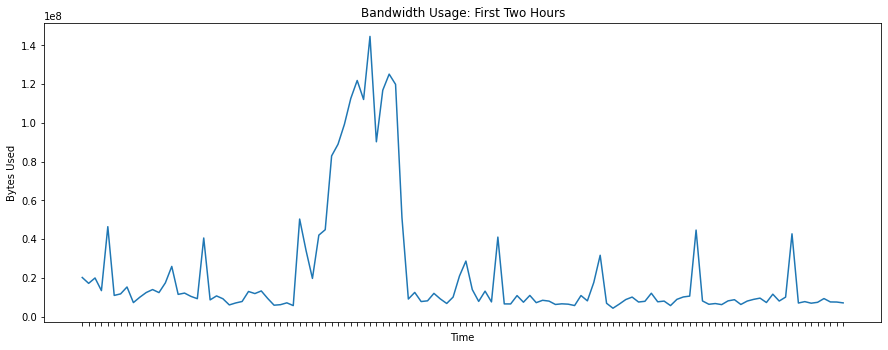

In [17]:
# plot the data
fig_dims = (15, 5.5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=df_interval_bandwidth,
    x='Interval Start',
    y='Bytes Used',
    ax=ax
).set(
    title='Bandwidth Usage: First Two Hours',
    xlabel='Time',
    xticklabels=[])

plt.show()

#### 4. Number of IP addresses in the last two hours

Notes:

- To count the number of local IP addresses use the `startswith` filter of `192.`
- The dataset contains incomplete intervals where `Interval End == 0` to indicate that the interval was not yet complete when the snapshot was taken.

In [18]:
# the filter on IP is to select only local IP addresses
df_interval_clients = spark.createDataFrame(df_interval_type \
    .where((df_interval_type['Interval Length'] == 'minute') & 
           (df_interval_type['interval_type'] == 'IP') &
           (df_interval_type['IP'].startswith('192.')) &
           (df_interval_type['Interval End'] > 0)) \
    .drop_duplicates(['IP', 'Interval Start', 'Interval End']) \
    .groupBy(['Interval Start']) \
    .count() \
    .orderBy(['Interval Start'], ascending=True) \
    .tail(2 * 60)) \
    .toPandas()

df_interval_clients.describe()

,count
count,120.000000
mean,16.933333
std,0.967830
min,15.000000
25%,16.000000
50%,17.000000
75%,18.000000
max,19.000000


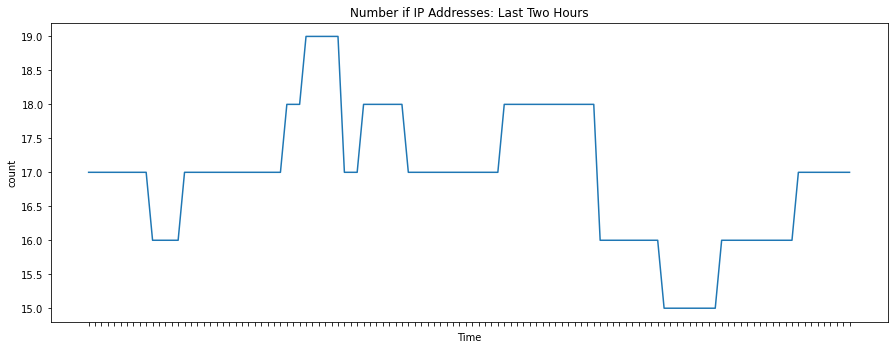

In [19]:
# plot the data
fig_dims = (15, 5.5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=df_interval_clients,
    x='Interval Start',
    y='count',
    ax=ax
).set(
    title='Number if IP Addresses: Last Two Hours',
    xlabel='Time',
    xticklabels=[])

plt.show()

In [23]:
# select only the minute data values
df_minute = df_interval_type \
    .where((df_interval_type['Interval Length'] == 'minute') & 
           (df_interval_type['interval_type'] == 'IP') &
           ((df_interval_type['Interval End'] > 0))) 

df_minute.count()

123573

In [38]:
# TODO: Testing windowing

# get the unique intervals
df_unique_intervals = df_minute \
    .drop_duplicates(['Interval Start', 'Interval End']) \
    .drop('Direction') \
    .drop('Interval Length') \
    .drop('Interval End') \
    .drop('IP') \
    .drop('Bytes Used') \
    .drop('interval_type')

interval_window = Window.partitionBy().orderBy('Interval Start')

# add the previous interval start value
df_prev = df_unique_intervals \
    .withColumn('prev_interval_start', lag('Interval Start', 1).over(interval_window))

# calculate the difference
df_prev = df_prev \
    .withColumn('diff', when(isnull(df_prev.prev_interval_start), 0) \
                       .otherwise(df_prev['Interval Start'] - df_prev['prev_interval_start']))


df_prev.show(10)


+--------------+-------------------+----+
|Interval Start|prev_interval_start|diff|
+--------------+-------------------+----+
|    1646430900|               null| 0.0|
|    1646430960|         1646430900|60.0|
|    1646431020|         1646430960|60.0|
|    1646431080|         1646431020|60.0|
|    1646431140|         1646431080|60.0|
|    1646431200|         1646431140|60.0|
|    1646431260|         1646431200|60.0|
|    1646431320|         1646431260|60.0|
|    1646431380|         1646431320|60.0|
|    1646431440|         1646431380|60.0|
+--------------+-------------------+----+
only showing top 10 rows



#### Find data gaps

In [43]:
df_prev.select('diff').summary().show()

+-------+------------------+
|summary|              diff|
+-------+------------------+
|  count|              3340|
|   mean| 60.07185628742515|
| stddev|5.2940702810848235|
|    min|               0.0|
|    25%|              60.0|
|    50%|              60.0|
|    75%|              60.0|
|    max|             360.0|
+-------+------------------+



In [46]:
df_prev.where('diff > 60').show()

+--------------+-------------------+-----+
|Interval Start|prev_interval_start| diff|
+--------------+-------------------+-----+
|    1646574900|         1646574540|360.0|
+--------------+-------------------+-----+

